### __Notebook to verify that looking at temperature amplitude ratio is interesting for a diffusive problem in the monodirectional case__ ###


In [139]:
#Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk 
from sklearn import linear_model
from pyheatmy import * 
from pyheatmy.core import *
import scipy

In [140]:
# Pour différentes valeurs de K
# On dispose d'un matrice de température : les lignes en temps constants, les colonnes en profondeurs constantes.
# Et d'une liste des temps et profondeurs correspondants.
# Il faut calculer les amplitudes à chaque profondeur, puis tracer ln(A_z / A_0).
# Enfin, vérifier si l'hypothèse linéaire est vérifiée, même pour un cas diffusif.

In [141]:
# Argument : la matrice, liste des profondeur
# Sortie : liste des amplitudes
def amplitude(T):
    amplitude_list = []
    for j in range(len(T[0,:])):
        T_max = max(T[:,j])
        T_min = min(T[:,j])
        A = (T_max - T_min) / 2
        amplitude_list.append(A)
    return amplitude_list


# Retourne ln(rapport des amplitudes) en fonction de la profondeur
def ln_amp(T):
    amplitude_list = amplitude(T)
    amplitude_array = np.array(amplitude_list)
    ln_rapport_amplitude = np.log( amplitude_array / amplitude_array[0] )
    return ln_rapport_amplitude


# Trace le ln_temp(T) en fonction de depths
def plot_ln_amp(depths, T):
    y = ln_amp(T)
    plt.plot(depths, y)
    plt.title("Logarithme du rapport des amplitudes")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.show()


# Renvoie l'instance de régression linéaire des données (profondeur, ln(rapport amplitudes))
def linear_regression(depths, T):
    y = ln_amp(T)
    return scipy.stats.linregress(depths, y)


# Trace l'interpolation linéaire en imprimant le coefficient d'exactitude
def plot_linear_regression(depths, T):
    # assert len(T) == lent(depths), "a temperature measure must be assigned to a single depth"
    X = np.array(depths).reshape(-1,1)
    Y = ln_amp(T)
    Lr = linear_regression(depths, T)
    Pearson_coefficient = Lr.rvalue
    slope = Lr.slope
    intercept = Lr.intercept
    lm = linear_model.LinearRegression()
    lm.fit(X, Y)
    plt.scatter(X, Y, color="r", marker="o", s=30)
    y_pred = lm.predict(X)
    plt.plot(X, y_pred, color="k")
    plt.xlabel("profondeur (unit)")
    plt.ylabel("ln(A_z / A_0)")
    plt.title("Régression linéaire sur le rapport des logarithmes des amplitudes")
    plt.figtext(.6, .8, "y = " + str(slope) + "x + " + str(intercept))
    plt.figtext(.6, .7, "Pearson coefficient : " + str(Pearson_coefficient))
    plt.show()


# Mosaïque des différentes courbes en fonction des valeurs de K (list_K = liste de ces valeurs)
# T est la liste des matrices de températures pour différentes valeurs de K
def plot_mosaic(depths, list_T, list_K):  
    # assert len(list_T[0]) == lent(depths), "a temperature measure must be assigned to a single depth"
    assert len(list_T) == len(list_K), 'The number of K values does not match the number a temperature matrices'
    n_rows = len(list_K)//2 + len(list_K)%2
    _, ax = plt.subplots(n_rows, ncols=2)
    X = np.array(depths).reshape(-1,1)
    for i in range(n_rows):
        for j in range(2):
            Y = ln_amp(list_T[2*i+j])
            Lr = linear_regression(depths, list_T[2*i+j])
            Pearson_coefficient = Lr.rvalue
            slope = Lr.slope
            intercept = Lr.intercept
            lm = linear_model.LinearRegression()
            lm.fit(X, Y)
            ax[i][j].scatter(X, Y, color="r", marker="o", s=30)
            y_pred = lm.predict(X)
            ax[i][j].plot(X, y_pred, color="k")
            ax[i][j].set_xlabel('profondeur (unit)')
            ax[i][j].set_ylabel('température')
            ax[i][j].set_title('Rapport des ln(A_z / A_0) avec K =' + str(list_K[2*i] + j), size = 10)   
            ax[i][j].legend(["Pearson coefficient : " + str(Pearson_coefficient)])


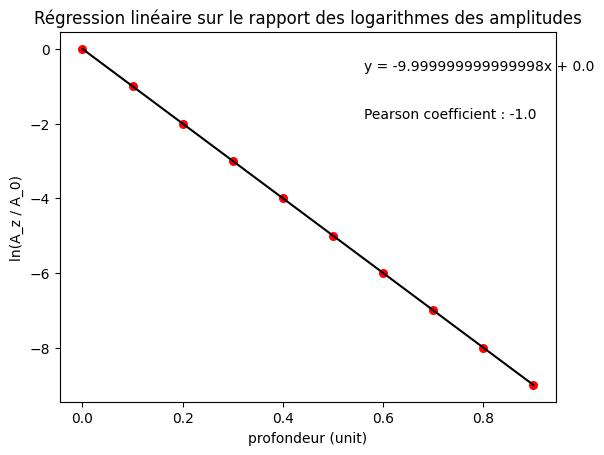

In [142]:
# test de plot_linear_regression
# Création d'un jeu de données arbitraire :

T = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        T[i,j] = np.sin(i) * np.exp(-j)

depths = [0.1 * i for i in range(10)]

plot_linear_regression(depths, T)

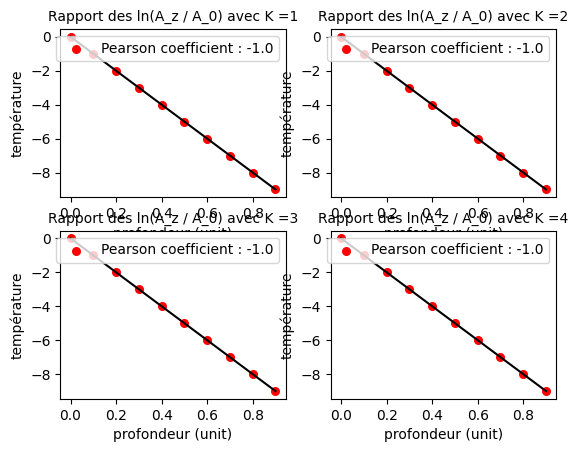

In [143]:
# test de plot_mosaic
# Création de 4 valeurs de K

list_K = range(1,5)
list_T = [T for _ in range(4)]

plot_mosaic(depths,list_T,list_K)